O objetivo deste trabalho é desenvolver um pipeline completo de modelagem preditiva utilizando o dataset Canine Wellness Dataset (Synthetic). O aluno deverá comparar os algoritmos K - Nearest Neighbors (KNN) e Random Forest para identificar qual deles apresenta o melhor desempenho no problema de classificação proposto.

O trabalho envolve : exploração e pré - processamento dos dados , aplicação de técnicas de amostragem , construção e avaliação de modelos , análise estatística para comparar classificadores e definição de uma estratégia de implantação (deploy) do modelo vencedor

In [66]:
import pandas as pd
import re
import matplotlib.pyplot as plt
import numpy as np

In [67]:
input_file = 'synthetic_dog_breed_health_data.csv' 

# --- 1. Cargar archivo ---
df = pd.read_csv(input_file)
df =df.drop(columns=["ID"], errors = "ignore")
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Breed                        9710 non-null   object 
 1   Breed Size                   9712 non-null   object 
 2   Sex                          9675 non-null   object 
 3   Age                          9709 non-null   float64
 4   Weight (lbs)                 9709 non-null   float64
 5   Spay/Neuter Status           6433 non-null   object 
 6   Daily Activity Level         7770 non-null   object 
 7   Diet                         9698 non-null   object 
 8   Food Brand                   9700 non-null   object 
 9   Daily Walk Distance (miles)  9706 non-null   float64
 10  Other Pets in Household      9702 non-null   object 
 11  Medications                  9751 non-null   object 
 12  Seizures                     9699 non-null   object 
 13  Hours of Sleep   

,Breed,Breed Size,Sex,Age,Weight (lbs),Spay/Neuter Status,Daily Activity Level,Diet,Food Brand,Daily Walk Distance (miles),Other Pets in Household,Medications,Seizures,Hours of Sleep,Play Time (hrs),Owner Activity Level,Annual Vet Visits,Average Temperature (F),Synthetic,Healthy
0,Australian Shepherd,Medium,Male,3.0,60.0,Neutered,NaN,NaN,Wellness,5.0,No,Yes,No,12.0,1.0,Active,1.0,30.0,Yes,Yes
1,Dachshund,NaN,Female,4.0,57.0,Neutered,Very Active,Home cooked,Special,2.0,Yes,No,No,11.0,3.0,NaN,0.0,47.0,Yes,NaN
2,Chihuahua,Small,Female,12.0,67.0,Neutered,Active,Home cooked,Special,1.0,Yes,No,No,10.0,1.0,Low,0.0,92.0,Yes,Yes
3,Siberian Husky,Medium,Male,13.0,35.0,NaN,Very Active,NaN,Special,4.0,No,No,No,12.0,NaN,NaN,1.0,75.0,Yes,Yes
4,Boxer,Medium,Male,13.0,35.0,NaN,Very Active,Wet food,Purina,3.0,Yes,Yes,No,9.0,1.0,NaN,0.0,64.0,Yes,No


**Exploratory**

En esta seccion vamos a tratar los datos, comenzado por la padronizacion de los nombres de las columnas

In [68]:
# --- CONFIGURACIÓN ---
#input_file = 'synthetic_dog_breed_health_data.csv'         # tu archivo original
output_file = "dataset_all.csv"    # archivo limpio

# --- 1. Cargar archivo ---
#df = pd.read_csv(input_file,index_col= 0)

# --- 2. Limpiar nombres de columnas ---
def clean_column_name(col):
    # Reemplazar espacios por guiones bajos
    col = col.replace(" ", "_")
    # Quitar paréntesis y otros caracteres problemáticos
    col = re.sub(r"[^\w_]", "", col)
    return col

df.columns = [clean_column_name(c) for c in df.columns]

# --- 3. Limpiar valores con espacios o caracteres especiales ---
def clean_value(val):
    if isinstance(val, str):
        # Reemplazar espacios por guiones bajos en los valores
        val = val.strip().replace(" ", "_")
        # Quitar caracteres raros
        val = re.sub(r"[^\w_.-]", "", val)
    return val

df = df.applymap(clean_value)

# --- 4. Guardar archivo limpio ---
df.to_csv(output_file, index=False)

print("Archivo limpio generado:", output_file)


C:\Users\bruan\AppData\Local\Temp\ipykernel_10576\2039925755.py:27: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(clean_value)


Archivo limpio generado: dataset_all.csv


In [69]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Breed                      9710 non-null   object 
 1   Breed_Size                 9712 non-null   object 
 2   Sex                        9675 non-null   object 
 3   Age                        9709 non-null   float64
 4   Weight_lbs                 9709 non-null   float64
 5   SpayNeuter_Status          6433 non-null   object 
 6   Daily_Activity_Level       7770 non-null   object 
 7   Diet                       9698 non-null   object 
 8   Food_Brand                 9700 non-null   object 
 9   Daily_Walk_Distance_miles  9706 non-null   float64
 10  Other_Pets_in_Household    9702 non-null   object 
 11  Medications                9751 non-null   object 
 12  Seizures                   9699 non-null   object 
 13  Hours_of_Sleep             9721 non-null   floa

In [70]:
conteo = df['Healthy'].value_counts()
print("Valores nulos:", df["Healthy"].isnull().sum())
conteo

Valores nulos: 322


Healthy
Yes    7178
No     2500
Name: count, dtype: int64

Es obsevado que se tienen valores nulos en la variable objetivo, estos casos de valores nulos seran eliminados luego de la imputacion para asi aprovechar la mayor cantidad de datos.

In [71]:
"""
# Hacemos drop de las clase objetivo NaN para eliminar el sesgo problemas con la prediccion y evitar riesgos de ruido
df = df.dropna(subset=["Healthy"])
df = df.reset_index(drop = True)
# --- 4. Guardar archivo limpio ---
df.to_csv(output_file, index=False)
"""

'\n# Hacemos drop de las clase objetivo NaN para eliminar el sesgo problemas con la prediccion y evitar riesgos de ruido\ndf = df.dropna(subset=["Healthy"])\ndf = df.reset_index(drop = True)\n# --- 4. Guardar archivo limpio ---\ndf.to_csv(output_file, index=False)\n'

In [72]:
df = pd.read_csv("dataset_all.csv")

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Breed                      9710 non-null   object 
 1   Breed_Size                 9712 non-null   object 
 2   Sex                        9675 non-null   object 
 3   Age                        9709 non-null   float64
 4   Weight_lbs                 9709 non-null   float64
 5   SpayNeuter_Status          6433 non-null   object 
 6   Daily_Activity_Level       7770 non-null   object 
 7   Diet                       9698 non-null   object 
 8   Food_Brand                 9700 non-null   object 
 9   Daily_Walk_Distance_miles  9706 non-null   float64
 10  Other_Pets_in_Household    9702 non-null   object 
 11  Medications                9751 non-null   object 
 12  Seizures                   9699 non-null   object 
 13  Hours_of_Sleep             9721 non-null   floa

Vamos a analizar los valores presentes en cada columna

In [73]:
df_columns = df.columns.tolist()
df_columns
#results_analysis = {}
results_nulls = {}
for i in df_columns:
    if df[i].dtype == 'float64':
        #results_analysis[i] = "numerical"
        print(i, "[numerical]")
    else:
        #results_analysis[i] = df[i].unique()
        print(i, df[i].unique())

    valor_nulo = df[i].isnull().sum()
    results_nulls[i] = valor_nulo
    print('valores nulos:', valor_nulo )

# Ordenamos el diccionario usando los valores
results_nulls = dict(sorted(results_nulls.items(), key=lambda item: item[1], reverse=True))


Breed ['Australian_Shepherd' 'Dachshund' 'Chihuahua' 'Siberian_Husky' 'Boxer'
 'Labrador_Retriever' 'Bulldog' 'Rottweiler' 'German_Shepherd'
 'Golden_Retriever' 'Poodle' 'Doberman' 'Great_Dane' 'Beagle'
 'Yorkshire_Terrier' nan]
valores nulos: 290
Breed_Size ['Medium' nan 'Small' 'Large']
valores nulos: 288
Sex ['Male' 'Female' nan]
valores nulos: 325
Age [numerical]
valores nulos: 291
Weight_lbs [numerical]
valores nulos: 291
SpayNeuter_Status ['Neutered' nan 'Spayed']
valores nulos: 3567
Daily_Activity_Level [nan 'Very_Active' 'Active' 'Moderate' 'Low']
valores nulos: 2230
Diet [nan 'Home_cooked' 'Wet_food' 'Special_diet' 'Hard_food']
valores nulos: 302
Food_Brand ['Wellness' 'Special' 'Purina' 'Iams' 'Blue_Buffalo' 'Royal_Canin' 'Nutro'
 'Pedigree' 'Hills_Science' nan]
valores nulos: 300
Daily_Walk_Distance_miles [numerical]
valores nulos: 294
Other_Pets_in_Household ['No' 'Yes' nan]
valores nulos: 298
Medications ['Yes' 'No' nan]
valores nulos: 249
Seizures ['No' 'Yes' nan]
valores

Ahora verificamos la cantidad de nulos en cada columna

SpayNeuter_Status 3567
Daily_Activity_Level 2230
Owner_Activity_Level 2227
Average_Temperature_F 345
Sex 325
Healthy 322
Synthetic 310
Play_Time_hrs 309
Annual_Vet_Visits 306
Diet 302
Seizures 301
Food_Brand 300
Other_Pets_in_Household 298
Daily_Walk_Distance_miles 294
Age 291
Weight_lbs 291
Breed 290
Breed_Size 288
Hours_of_Sleep 279
Medications 249


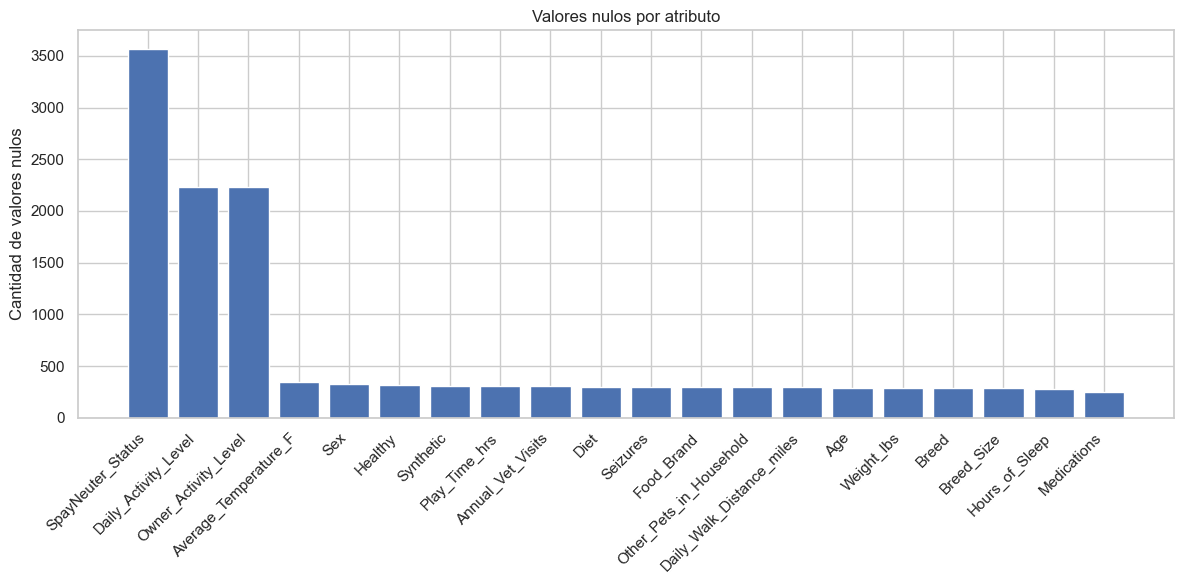

In [74]:
for clave, valor in results_nulls.items():
    print(clave,valor)

# Extraer claves y valores
columnas = list(results_nulls.keys())
nulos = list(results_nulls.values())

plt.figure(figsize=(12, 6))
plt.bar(columnas, nulos)

plt.xticks(rotation=45, ha='right')
plt.ylabel("Cantidad de valores nulos")
plt.title("Valores nulos por atributo")

plt.tight_layout()
plt.show()

*Podemos ver que las columnas criticas a tratar por la cantidad de nulos son las columnas:*

- SpayNeuter_Status
- Daily_Activity_Level 
- Owner_Activity_Level

*Estos valores nulos son desconocidos, entonces vamos a rellenar estos valores faltantes creando una categoria Unknown.*

*Tambien vamos a rellenar los nulos del atributo Breed con Unknown para no perder la informacion contenida en esos casos.*

*Descartamos el atributo 'Synthetic' ya que este posee solo un valor.*

In [75]:
# 1. Imputación de Variables con MUCHOS nulos (>2000)
# Creamos una categoría explícita para no introducir ruido
cols_high_nulls = ['SpayNeuter_Status', 'Daily_Activity_Level', 'Owner_Activity_Level', 'Breed']
for col in cols_high_nulls:
    df[col] = df[col].fillna('Unknown')

# Hacemos drop de la columan Synthetic

df.drop('Synthetic', axis=1, inplace=True)

*Hipotesis: El atributo Weight esta correlacionado con el atributo Breed_Size*

Vamos a verificar esto y en caso de que la hipotesis sea correcta vamos a rellenar los valores nulos de Breed_size con lo valores de Weight.

Para ello deberiamos de observar que a mayor tamaño de la raza se tiene un valor medio mayor en el peso.

C:\Users\bruan\AppData\Local\Temp\ipykernel_10576\2750278184.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


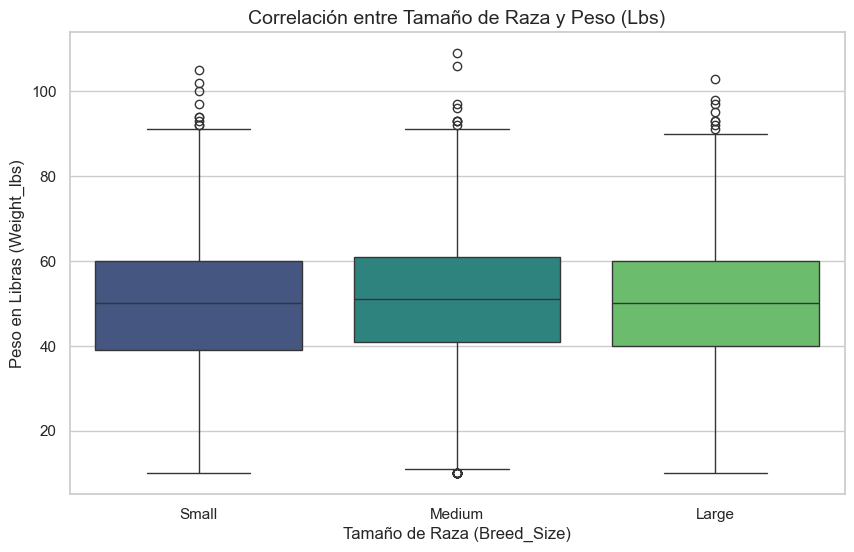

In [76]:
import seaborn as sns

# 1. Configurar el estilo del gráfico
plt.figure(figsize=(10, 6))
sns.set_theme(style="whitegrid")

# 2. Definir el orden lógico de las categorías para que el gráfico sea legible
order_sizes = ['Small', 'Medium', 'Large']

# 3. Crear el Box Plot
# Esto muestra la mediana, cuartiles y outliers del peso para cada tamaño
sns.boxplot(
    data=df, 
    x='Breed_Size', 
    y='Weight_lbs', 
    order=order_sizes,
    palette="viridis"
)

# 4. Añadir títulos y etiquetas
plt.title('Correlación entre Tamaño de Raza y Peso (Lbs)', fontsize=14)
plt.xlabel('Tamaño de Raza (Breed_Size)', fontsize=12)
plt.ylabel('Peso en Libras (Weight_lbs)', fontsize=12)

# 5. Mostrar el gráfico
plt.show()

*Hipotesis Falsa!*

No se tiene una correlacion entre os valores entre el peso y el tamaño de la raza.

Ahora, como el atributo Breed_Size no refleja una caracteristica real, este atributo no aporta un valor predictivo en el modelo, entonces vamos a descartar el atributo del dataset.

In [77]:
df.drop(['Breed_Size'], axis=1, inplace=True)

*Ahora vamos a graficar los valores numéricos para visualizar su distribución*

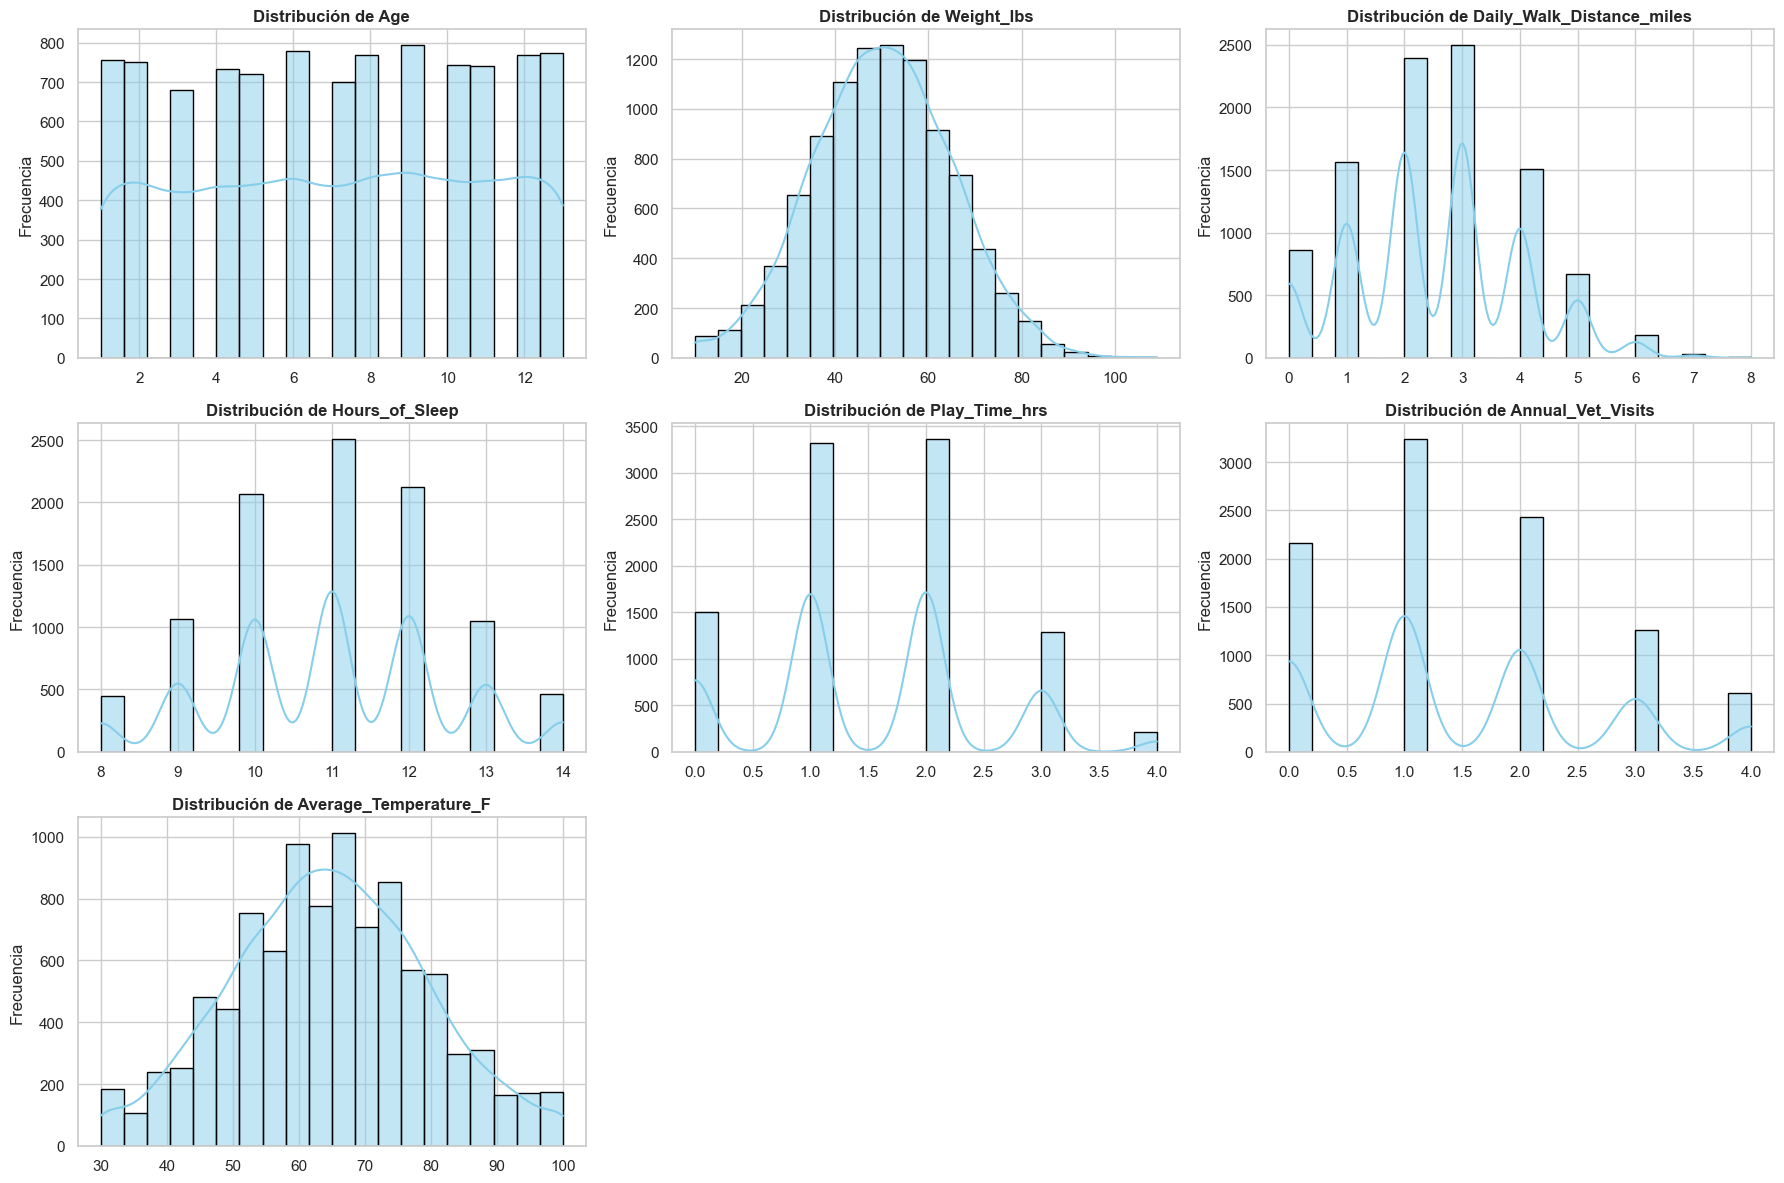

In [78]:
import math

# Lista de columnas numéricas
num_cols = ['Age', 'Weight_lbs', 'Daily_Walk_Distance_miles', 'Hours_of_Sleep', 
            'Play_Time_hrs', 'Annual_Vet_Visits', 'Average_Temperature_F']

# Configuración del grid (filas y columnas dinámicas)
n_cols = 3
n_rows = math.ceil(len(num_cols) / n_cols)

plt.figure(figsize=(18, 4 * n_rows))
sns.set_theme(style="whitegrid")

for i, col in enumerate(num_cols):
    ax = plt.subplot(n_rows, n_cols, i + 1)
    
    # Opción A: Histograma con curva de densidad (KDE)
    sns.histplot(data=df, x=col, kde=True, color="skyblue", edgecolor="black", bins=20)
    
    plt.title(f'Distribución de {col}', fontsize=12, fontweight='bold')
    plt.xlabel('') # Limpiamos etiqueta x para no saturar
    plt.ylabel('Frecuencia')

plt.tight_layout()
plt.show()

In [79]:
num_cols_disc = ['Age', 'Daily_Walk_Distance_miles', 'Hours_of_Sleep', 
            'Play_Time_hrs', 'Annual_Vet_Visits']

for i in num_cols_disc:
    print(i, df[i].unique())

Age [ 3.  4. 12. 13.  2.  8. 11. nan  5. 10.  7.  9.  6.  1.]
Daily_Walk_Distance_miles [ 5.  2.  1.  4.  3.  0. nan  6.  7.  8.]
Hours_of_Sleep [12. 11. 10.  9.  8. 13. 14. nan]
Play_Time_hrs [ 1.  3. nan  2.  0.  4.]
Annual_Vet_Visits [ 1.  0.  2.  4. nan  3.]


Podemos observar en los graficos que:

- Tenemos distribuciones normales en los atributos Weight_lbs y Average_Temperature_F. De esta forma, para tratar los valores nulos seria una mejor practica usar imputacion por la Media, ya que seria un mejor estimador.
- Para los atributos; Daily_Walk_Distance_miles, Hours_of_Sleep, Play_Time_hrs, Annual_Vet_Visits, Age. Se observa una distribucion no normal, plana para el caso del atributo Age y variables discretas con picos definidos para los demas atributos, debido a esto la imputacion por la media seria la mejor opcion.

**Pre-Procesamiento (Split e Imputación) y Entrenamiento**

Primeramente analizamos la distribucion de las clases para saber si necesitamos balanceo y calculamos el error de la clase mayoritaria para determinar el baseline de los modelos a entrenar.

Error de la clase mayoritaria: 65.17135692393424 %


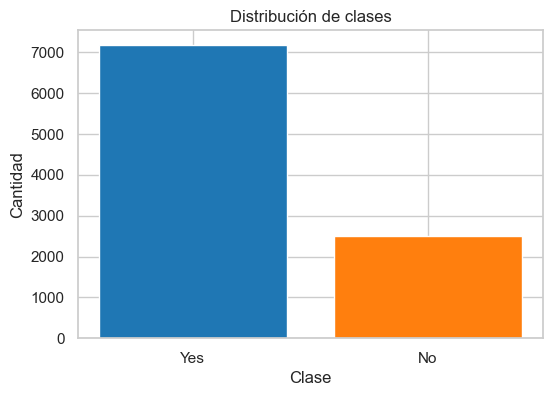

In [80]:
# Analizamos el error de la clase minoritaria

Yes_class = df['Healthy'].value_counts().iloc[0]
No_class = df['Healthy'].value_counts().iloc[1]

error_class = 1 - (No_class/Yes_class)
print('Error de la clase mayoritaria:', error_class*100, "%")

# Colores solicitados
colores = ['#1f77b4', '#ff7f0e']

# Gráfico de la distribucion de clases
plt.figure(figsize=(6,4))
plt.bar(conteo.index, conteo.values, color=colores)

plt.xlabel('Clase')
plt.ylabel('Cantidad')
plt.title('Distribución de clases')
plt.show()

Podemos ver que no tenemos un desblanceo muy grande, de esta forma no necesitaremos de ningun balanceo.

Ahora aplicamos el Pre-Procesamiento siguiendo la estrategia de imputación mencionada anteriormente.

Entrenamiento (80%): (7742, 17)
Validación (5%):    (484, 17)
Prueba/Test (15%):   (1452, 17)

⏳ Benchmark con n = 200 muestras...

⏳ Benchmark con n = 400 muestras...

⏳ Benchmark con n = 800 muestras...

⏳ Benchmark con n = 7742 muestras...


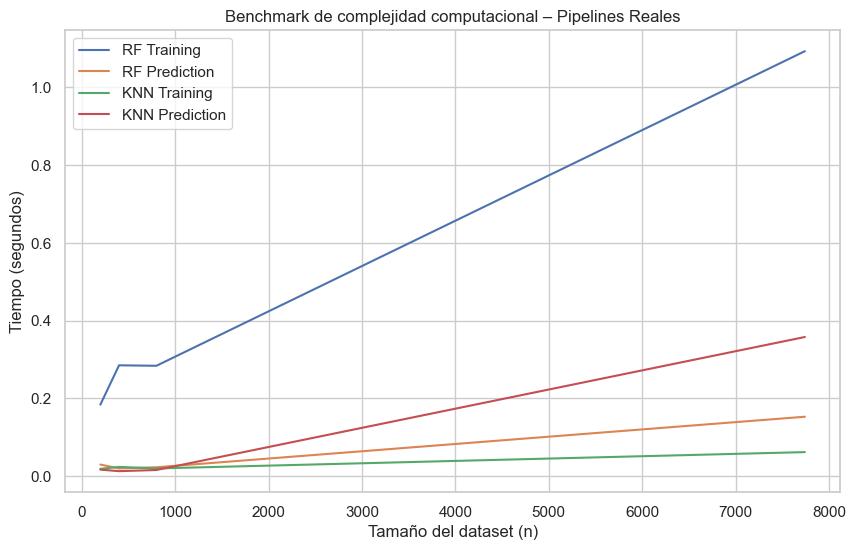


--- Evaluando KNN (5 Folds) ---
Accuracy Promedio: 0.8223 (+/- 0.0097)
F1-Score Promedio: 0.8029

--- Evaluando Random Forest (5 Folds) ---
Accuracy Promedio: 0.9286 (+/- 0.0077)
F1-Score Promedio: 0.9260

🧪 TEST DE SIGNIFICANCIA (WILCOXON)
Resultados KNN por fold: [0.8173 0.8231 0.8307 0.8178 0.8224]
Resultados RF por fold:  [0.927  0.9303 0.9348 0.9231 0.9276]
Estadístico W: 0.0, P-Value: 0.06250

❌ RESULTADO: NO hay diferencia significativa entre los modelos.
Ambos funcionan igual de bien (estadísticamente).


In [81]:
import pandas as pd
import numpy as np
from scipy.stats import wilcoxon # <--- Nueva librería para el test
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report


# ==========================================
# PASO 0: CARGA Y LIMPIEZA INICIAL
# ==========================================
# Asumimos que 'df' ya está cargado
# Eliminamos filas donde la variable objetivo 'Healthy' sea nula
df_clean = df.dropna(subset=['Healthy']).copy()

# Separar Features (X) y Target (y)

X = df_clean.drop('Healthy', axis=1)
y = df_clean['Healthy']

# ==========================================
# PASO 1: DIVISIÓN DE DATOS (80% Train / 10% Val / 10% Test)
# ==========================================
# Primera división: 80% Train vs 20% Temporal
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

#Utilzaremos la validación como datos de prueba durante el deploy
# Segunda división: Dividimos el 20% temporal en dos partes (15% test + 5% val)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.75, random_state=42, stratify=y_temp
)


print(f"Entrenamiento (80%): {X_train.shape}")
print(f"Validación (5%):    {X_val.shape}")
print(f"Prueba/Test (15%):   {X_test.shape}")

# ==========================================
# PASO 2: ESTRATEGIA DE COLUMNAS
# ==========================================
cols_normales = ['Weight_lbs', 'Average_Temperature_F']
cols_sesgadas = ['Age', 'Daily_Walk_Distance_miles', 'Hours_of_Sleep', 
                 'Play_Time_hrs', 'Annual_Vet_Visits']
cols_categoricas = X.select_dtypes(include=['object', 'category']).columns.tolist()

# ==========================================
# PASO 3 Y 4: PREPROCESADORES Y PIPELINES
# ==========================================
# Para atributos numericos con distribucion normal: Aplicamos imputación por la media.
# Para atributos numericos con distribución no normal: Imputación por la mediana.
# Par atributos categoricos: Imputación por la moda. 

# --- PREPROCESADOR KNN ---
preprocessor_knn = ColumnTransformer([
    ('num_normal', Pipeline([
        ('imputer', SimpleImputer(strategy='mean')),
        ('scaler', StandardScaler()) 
    ]), cols_normales),
    ('num_sesgada', Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler()) 
    ]), cols_sesgadas),
    ('cat', Pipeline([
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
    ]), cols_categoricas)
])

# --- PREPROCESADOR RF ---
preprocessor_rf = ColumnTransformer([
    ('num_normal', SimpleImputer(strategy='mean'), cols_normales),
    ('num_sesgada', SimpleImputer(strategy='median'), cols_sesgadas),
    ('cat', Pipeline([
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
    ]), cols_categoricas)
])

# --- PIPELINES ---
pipeline_knn = Pipeline([
    ('preprocessor', preprocessor_knn),
    ('classifier', KNeighborsClassifier(n_neighbors=5, weights='distance'))
])

pipeline_rf = Pipeline([
    ('preprocessor', preprocessor_rf),
    ('classifier', RandomForestClassifier(
        n_estimators=100, 
        random_state=42, 
        class_weight='balanced'
    ))
])

# ==========================================
# BENCHMARK ADAPTADO A TUS PIPELINES
# ==========================================
import time
import matplotlib.pyplot as plt

# Vamos a evaluar el tiempo para distintos tamaños del set de entrenamiento
sizes = [200, 400, 800, len(X_train)]  # Ajustable según tu dataset

rf_train_times = []
rf_pred_times = []
knn_train_times = []
knn_pred_times = []

for n in sizes:
    print(f"\n⏳ Benchmark con n = {n} muestras...")

    X_subset = X_train.iloc[:n]
    y_subset = y_train.iloc[:n]

    # ===== RANDOM FOREST =====
    start = time.time()
    pipeline_rf.fit(X_subset, y_subset)
    rf_train_times.append(time.time() - start)

    start = time.time()
    pipeline_rf.predict(X_subset)
    rf_pred_times.append(time.time() - start)

    # ===== KNN =====
    start = time.time()
    pipeline_knn.fit(X_subset, y_subset)
    knn_train_times.append(time.time() - start)

    start = time.time()
    pipeline_knn.predict(X_subset)
    knn_pred_times.append(time.time() - start)

# ==========================================
# GRÁFICO DEL BENCHMARK
# ==========================================
plt.figure(figsize=(10,6))
plt.plot(sizes, rf_train_times, label="RF Training")
plt.plot(sizes, rf_pred_times, label="RF Prediction")
plt.plot(sizes, knn_train_times, label="KNN Training")
plt.plot(sizes, knn_pred_times, label="KNN Prediction")

plt.xlabel("Tamaño del dataset (n)")
plt.ylabel("Tiempo (segundos)")
plt.title("Benchmark de complejidad computacional – Pipelines Reales")
plt.legend()
plt.grid(True)
plt.show()


# ==========================================
# PASO 5: EVALUACIÓN ESTADÍSTICA (MODIFICADO)
# ==========================================
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

def obtener_scores_cv(pipeline, X, y, nombre):
    print(f"\n--- Evaluando {nombre} (5 Folds) ---")
    # Usamos accuracy para el test de Wilcoxon (es más robusto comparar accuracy pura)
    # Pero imprimimos F1 para tu referencia sobre el desbalance
    acc_scores = cross_val_score(pipeline, X, y, cv=cv, scoring='accuracy')
    f1_scores = cross_val_score(pipeline, X, y, cv=cv, scoring='f1_weighted')
    
    print(f"Accuracy Promedio: {acc_scores.mean():.4f} (+/- {acc_scores.std()*2:.4f})")
    print(f"F1-Score Promedio: {f1_scores.mean():.4f}")
    
    # Retornamos ARRAY COMPLETO de scores para el test estadístico
    return acc_scores 

# 1. Obtenemos los arrays de resultados (5 números cada uno)
scores_knn = obtener_scores_cv(pipeline_knn, X_train, y_train, "KNN")
scores_rf = obtener_scores_cv(pipeline_rf, X_train, y_train, "Random Forest")

# 2. Aplicamos Test de Wilcoxon
print("\n========================================")
print("🧪 TEST DE SIGNIFICANCIA (WILCOXON)")
print("========================================")

# Comparar arrays: ¿Son sistemáticamente diferentes?
stat, p_value = wilcoxon(scores_rf, scores_knn)

print(f"Resultados KNN por fold: {np.round(scores_knn, 4)}")
print(f"Resultados RF por fold:  {np.round(scores_rf, 4)}")
print(f"Estadístico W: {stat}, P-Value: {p_value:.5f}")

# Interpretación automática
alpha = 0.05
diferencia_significativa = p_value < alpha

if diferencia_significativa:
    print("\n✅ RESULTADO: Existe una diferencia ESTADÍSTICAMENTE SIGNIFICATIVA.")
    if scores_rf.mean() > scores_knn.mean():
        ganador = "Random Forest"
        modelo_ganador = pipeline_rf
    else:
        ganador = "KNN"
        modelo_ganador = pipeline_knn
    print(f"El modelo {ganador} es superior con un 95% de confianza.")
else:
    print("\n❌ RESULTADO: NO hay diferencia significativa entre los modelos.")
    print("Ambos funcionan igual de bien (estadísticamente).")
    # En caso de empate, elegimos Random Forest por ser generalmente más robusto en producción
    # o el que tenga mejor media aritmética simple.
    if scores_rf.mean() >= scores_knn.mean():
        ganador = "Random Forest (Por media simple)"
        modelo_ganador = pipeline_rf
    else:
        ganador = "KNN (Por media simple)"
        modelo_ganador = pipeline_knn

Vimos que no existe diferencia estadistica significativa entre modelos. Entonces siendo el modelo de Random Forest el que presenta un menor coste computacional de predicción.

In [82]:
# ==========================================
# PASO 6: ENTRENAMIENTO Y EVALUACIÓN EN VALIDACIÓN
# ==========================================
print(f"\n🏆 MODELO SELECCIONADO: {ganador}")
print("Entrenando modelo final con TODO el set de Train...")
modelo_ganador.fit(X_train, y_train)

# Evaluación intermedia con VALIDACIÓN (para ajustar hiperparámetros si fuera necesario)
print("\n--- Evaluación en VALIDACIÓN SET (Para ajustes) ---")
y_pred_val = modelo_ganador.predict(X_val)
print(classification_report(y_val, y_pred_val))

# ==========================================
# PASO 7: EVALUACIÓN FINAL EN TEST (Solo una vez al final del proyecto)
# ==========================================
print("\n--- 🔒 Evaluación Final en TEST SET (Datos nunca vistos) ---")
y_pred_test = modelo_ganador.predict(X_test)
print(classification_report(y_test, y_pred_test))


🏆 MODELO SELECCIONADO: Random Forest (Por media simple)
Entrenando modelo final con TODO el set de Train...

--- Evaluación en VALIDACIÓN SET (Para ajustes) ---
              precision    recall  f1-score   support

          No       0.97      0.78      0.86       125
         Yes       0.93      0.99      0.96       359

    accuracy                           0.94       484
   macro avg       0.95      0.88      0.91       484
weighted avg       0.94      0.94      0.93       484


--- 🔒 Evaluación Final en TEST SET (Datos nunca vistos) ---
              precision    recall  f1-score   support

          No       0.95      0.77      0.85       375
         Yes       0.93      0.99      0.95      1077

    accuracy                           0.93      1452
   macro avg       0.94      0.88      0.90      1452
weighted avg       0.93      0.93      0.93      1452



Evaluamos tambien el desempeño del KNN

In [83]:
# ==========================================
# PASO 6: ENTRENAMIENTO Y EVALUACIÓN EN VALIDACIÓN
# ==========================================
print(f"\n🏆 EVALUACION KNN")
print("Entrenando modelo final con TODO el set de Train...")
pipeline_knn.fit(X_train, y_train)

# Evaluación intermedia con VALIDACIÓN (para ajustar hiperparámetros si fuera necesario)
print("\n--- Evaluación en VALIDACIÓN SET (Para ajustes) ---")
y_pred_val = pipeline_knn.predict(X_val)
print(classification_report(y_val, y_pred_val))

# ==========================================
# PASO 7: EVALUACIÓN FINAL EN TEST (Solo una vez al final del proyecto)
# ==========================================
print("\n--- 🔒 Evaluación Final en TEST SET (Datos nunca vistos) ---")
y_pred_test = pipeline_knn.predict(X_test)
print(classification_report(y_test, y_pred_test))


🏆 EVALUACION KNN
Entrenando modelo final con TODO el set de Train...

--- Evaluación en VALIDACIÓN SET (Para ajustes) ---
              precision    recall  f1-score   support

          No       0.74      0.41      0.53       125
         Yes       0.82      0.95      0.88       359

    accuracy                           0.81       484
   macro avg       0.78      0.68      0.70       484
weighted avg       0.80      0.81      0.79       484


--- 🔒 Evaluación Final en TEST SET (Datos nunca vistos) ---
              precision    recall  f1-score   support

          No       0.79      0.44      0.57       375
         Yes       0.83      0.96      0.89      1077

    accuracy                           0.83      1452
   macro avg       0.81      0.70      0.73      1452
weighted avg       0.82      0.83      0.81      1452



**RESULTADOS**

| Métrica             | Random Forest | KNN      | Best model    |
| ------------------- | ------------- | -------- | --------------- |
| **Accuracy**        | **0.94**      | 0.81     | RF              |
| **Precision (No)**  | 0.97          | 0.74     | RF              |
| **Precision (Yes)** | **0.93**      | 0.82     | RF              |
| **Recall (No)**     | **0.78**      | 0.41     | RF              |
| **Recall (Yes)**    | 0.99          | **0.95** | RF (casi igual) |
| **F1 (No)**         | 0.86          | 0.53     | RF              |
| **F1 (Yes)**        | 0.96          | 0.88     | RF              |
| **Macro F1**        | **0.91**      | 0.70     | RF              |
| **Weighted F1**     | **0.93**      | 0.79     | RF              |


Podemos observar que el modelo de Random Forest tuvo un mejor desempeño de forma general mientras que el KNN tuvo un especial dificultad para acertar los casos de la clase minoritaria (Recall = No).

Teniendo en cuenta que el modelo de Random Forest presento un mejor desempeño en predecir los valores y tambien un coste computacional para predicción menor. Seleccionamos a este modelo para producción.

In [84]:
# Verificamos la importancia de cada variableen la predicción
rf = pipeline_rf.named_steps["classifier"]
importances = rf.feature_importances_

# nombres después del preprocesamiento
feature_names = pipeline_rf.named_steps["preprocessor"].get_feature_names_out()

for name, imp in sorted(zip(feature_names, importances), key=lambda x: -x[1]):
    print(name, imp)


num_sesgada__Age 0.11008561170357642
num_sesgada__Annual_Vet_Visits 0.08862744515958305
cat__SpayNeuter_Status_Unknown 0.07431033100457607
cat__Medications_Yes 0.05768636635095536
cat__Medications_No 0.05417539955187715
num_normal__Weight_lbs 0.05261291698955995
num_normal__Average_Temperature_F 0.04027583755502344
cat__Daily_Activity_Level_Very_Active 0.03623563205839327
cat__Daily_Activity_Level_Active 0.033982376125767794
cat__Diet_Special_diet 0.032402364174523086
num_sesgada__Daily_Walk_Distance_miles 0.024736986211998307
num_sesgada__Hours_of_Sleep 0.02341467335742704
cat__Food_Brand_Special 0.022734996138415547
cat__Diet_Home_cooked 0.02179532718874725
cat__SpayNeuter_Status_Spayed 0.020181384554406878
cat__SpayNeuter_Status_Neutered 0.01986255694054913
cat__Diet_Wet_food 0.018891412553503913
num_sesgada__Play_Time_hrs 0.018543453833278774
cat__Diet_Hard_food 0.01800930139910157
cat__Seizures_Yes 0.016589883450445837
cat__Seizures_No 0.01542727805853125
cat__Daily_Activity_Level

In [85]:
# ==========================================
# PASO 8: GUARDAR MODELO PARA DEPLOY (JOBLIB)
# ==========================================
import joblib
import os

# Carpeta donde guardar el modelo
os.makedirs("model_artifacts", exist_ok=True)

# Archivo destino
model_path = "model_artifacts/random_forest_pipeline.pkl"

joblib.dump(modelo_ganador, model_path)

print(f"\n📦 Modelo guardado exitosamente en: {model_path}")



📦 Modelo guardado exitosamente en: model_artifacts/random_forest_pipeline.pkl


**Deploy**

La estrategia de deploy que vamos a utilizar es un deploy local usando containers. Para mas informacion consultar los links:


https://medium.com/@victormacedo996/estrat%C3%A9gias-de-deploy-de-modelos-online-de-ml-parte-1-a45d648c68a7

https://www.reddit.com/r/mlops/comments/17akbyn/ml_model_deployment_a_practical_3part_guide/?tl=es-419

Deploying a Machine Learning model — Getting started:

https://medium.com/@TejasEkawade/deploying-a-machine-learning-model-getting-started-2644392c8953

Deploying a Machine Learning Model: Part 2 — Local Deployment:

https://medium.com/@TejasEkawade/deploying-a-machine-learning-model-part-2-local-deployment-1c36d029ce7a





In [86]:
# Guardamos el metadato del modelo con mlem.api

from mlem.api import save

# Guardamos el modelo e indicamos la estructura de los datos con sample_data
save(modelo_ganador, "model_artifacts/RF", sample_data=X_train)

MlemModel(location=Location(path='d:/Archivos/Maestria/IML/Trabalho 2/model_artifacts/RF.mlem', project=None, rev=None, uri='file://d:/Archivos/Maestria/IML/Trabalho 2/model_artifacts/RF.mlem', project_uri=None, fs=<fsspec.implementations.local.LocalFileSystem object at 0x000001E113389490>), params={}, artifacts={'data': LocalArtifact(uri='RF', size=17592389, hash='d264601559ffb36d3da1433573df5423')}, requirements=Requirements(__root__=[InstallableRequirement(module='numpy', version='2.2.6', package_name=None, extra_index=None, source_url=None, vcs=None, vcs_commit=None), InstallableRequirement(module='pandas', version='2.2.2', package_name=None, extra_index=None, source_url=None, vcs=None, vcs_commit=None), InstallableRequirement(module='sklearn', version='1.5.2', package_name='scikit-learn', extra_index=None, source_url=None, vcs=None, vcs_commit=None)]), processors_cache={'model': SklearnPipelineType(model=Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transform

Probamos la predicción primeramente con joblib (mas rápido)

In [90]:
import joblib
import pandas as pd

# Cargar modelo
modelo = joblib.load("model_artifacts/random_forest_pipeline.pkl")

# ====================================
# TOMAR UNA FILA DE X_val PARA PREDECIR
# ====================================
fila = 10  # <---- puedes cambiar la fila que quieres usar
example = X_val.iloc[[fila]]  # importante usar [[ ]] para mantener DataFrame

#print("Fila usada para la predicción:")
#print(example)

# ====================================
# 4. PREDICCIÓN
# ====================================
pred = modelo.predict(example)
proba = modelo.predict_proba(example)

print("\nPredicción:", pred[0])
print("Probabilidades:", proba[0])



Predicción: Yes
Probabilidades: [0.18 0.82]


Ahora probamos el modelo con mlem que nos servira para hacer el deploy

In [ ]:
#Testamos o modelo
from mlem.api import load
import pandas as pd

model = load("model_artifacts/RF")  # RandomForestClassifier
features = [
    "Breed",
    "Sex",
    "Age",
    "Weight_lbs",
    "SpayNeuter_Status",
    "Daily_Activity_Level",
    "Diet",
    "Food_Brand",
    "Daily_Walk_Distance_miles",
    "Other_Pets_in_Household",
    "Medications",
    "Seizures",
    "Hours_of_Sleep",
    "Play_Time_hrs",
    "Owner_Activity_Level",
    "Annual_Vet_Visits",
    "Average_Temperature_F",
]

#example = pd.DataFrame([[0, 1, 2, 3]], columns=features) #tambien podemos informar los valores de forma manual

#Usamos los valores de X_val para probar el modelo
fila = 10  # <---- puedes cambiar la fila que quieres usar
example = X_val.iloc[[fila]]  # importante usar [[ ]] para mantener DataFrame
y_pred = model.predict(example)
y_pred_proba = model.predict_proba(example)

print("Result (Healthy?) = ", y_pred)
print("Probability", y_pred_proba)

Result (Healthy?) =  ['Yes']
Probability [[0.18 0.82]]


Here are the following steps for deploying a model locally:

- Set up a virtual environment and install the required packages
- Build and save the model
- Serve the model locally
- Create a folder structure for files
- Build a docker image
- Spin up a container to run the application
- Test the model endpoint

| Stage                   | Details                                                                   |
| ----------------------- | ------------------------------------------------------------------------- |
| Development Environment | Virtual Environment, Python packages: pandas, scikit-learn, mlem[fastapi] |
| Model Development       | Random Forest Classifier, Training on Iris Dataset, scikit-learn          |
| Model Packaging         | MLEM Library, Model Serialization, Metadata (.mlem file)                  |
| Local Serving           | MLEM + FastAPI Server, REST API Endpoint, Port: 8080                      |
| Containerization        | Docker Build, Dockerfile + requirements.txt, Docker Image                 |
| Deployment              | Docker Container, Running Application, Port Mapping 8080:8080             |
| Testing & Interface     | Swagger UI, API Endpoint Testing, predict_proba endpoint                  |

Falta :

- Cambiar el idioma de los markdowns
- Comentar como se puede hacer run del modelo usando docker.
- Comentar que tambien se puede hacer pruebas del modelo usando joblib